# **1. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# **2. Load Data**

(433, 90, 90)


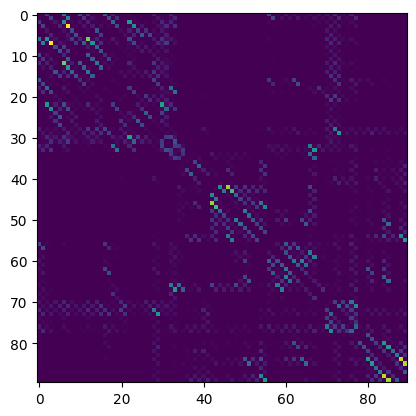

In [2]:
# load connectivity matrices
import pickle
matrices = pickle.load( open( "/content/drive/MyDrive/DATA SCIENCE 2024/classification_of_prematurity_using_structural_connectivity/data/matrices.p", "rb" ) )
print(matrices.shape)
plt.imshow(matrices[1,:,:])

In [3]:
# convert upper triangles of the matrices to feature vectors

# dimensions
n = matrices.shape[0]
m = matrices.shape[1]
D = round(m*(m-1)/2)
print('n={}, D={}'.format(n,D))

# feature matrix
X=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index]=matrices[i,j,k]
            index=index+1
print(X.shape)

n=433, D=4005
(433, 4005)


In [4]:
# load subject info
subject_info = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE 2024/classification_of_prematurity_using_structural_connectivity/data/subject_info.csv')
subject_info

,age,prematurity
0,41,0
1,41,0
2,40,0
3,41,0
4,41,0
...,...,...
428,44,0
429,41,0
430,44,0
431,42,0


In [5]:
# load gray matter region descriptions
label_names = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE 2024/classification_of_prematurity_using_structural_connectivity/data/label_names.csv')
label_names

,Label,Region name,Region description
0,1.0,Precentral_L,Precental gyrus
1,2.0,Precentral_R,Precental gyrus
2,3.0,Frontal_Sup_L,"Superior frontal gyrus, dorsolateral"
3,4.0,Frontal_Sup_R,"Superior frontal gyrus, dorsolateral"
4,5.0,Frontal_Sup_Orb_L,"Superior frontal gyrus, orbital part"
...,...,...,...
85,86.0,Temporal_Mid_R,Middle temporal gyrus
86,87.0,Temporal_Pole_Mid_L,Temporal pole: middle temporal gyrus
87,88.0,Temporal_Pole_Mid_R,Temporal pole: middle temporal gyrus
88,89.0,Temporal_Inf_L,Inferior temporal gyrus


# **3. Preprocessing**

In [6]:
# Feature matrix

# matrix X and scale the features
X = StandardScaler().fit_transform(X)

# Extract label vector
y = subject_info.to_numpy()[:,1]

In [7]:
# Check how many samples and features
print('Number of samples: ',X.shape[0])
print('Number of features: ',X.shape[1])

# Check how many samples of each class
print('Label vector (all samples): ', y.shape[0])
print('Label vector (term): ', y[y==0].shape[0])
print('Label vector (preterm): ', y[y==1].shape[0])
print('Proportion of preterms:', np.round(y[y==1].shape[0]/y.shape[0],2))

Number of samples:  433
Number of features:  4005
Label vector (all samples):  433
Label vector (term):  346
Label vector (preterm):  87
Proportion of preterms: 0.2


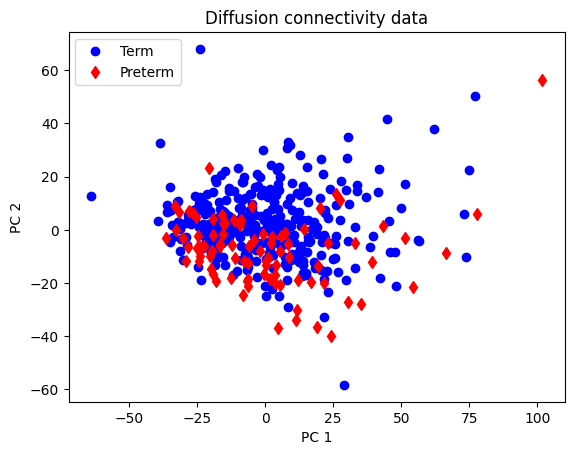

In [8]:
# Visualise the dataset using PCA
transf = PCA(n_components=2)
X_reduced = transf.fit_transform(X)

# Plot the data
def plotData(X,y):
    plt.plot(X[y==0,0],X[y==0,1],'bo', label = 'Term')
    plt.plot(X[y==1,0],X[y==1,1],'rd', label = 'Preterm')
    plt.legend()
    plt.title('Diffusion connectivity data')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

plotData(X_reduced,y)

# **4. Evaluation Framework**

## **4.1 Stratified Train-Test Split**

Text(0.5, 1.0, 'test set')

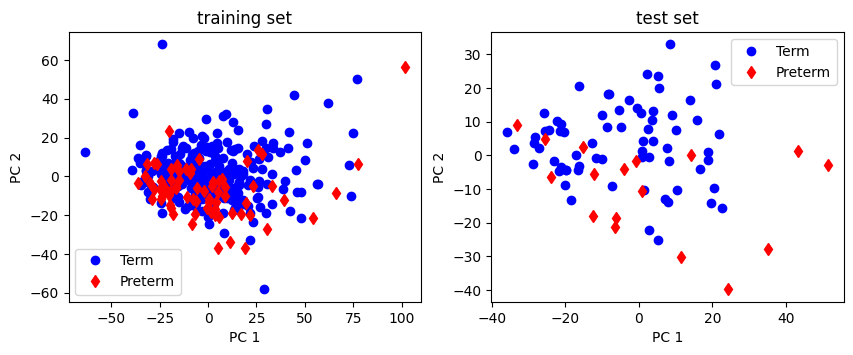

In [9]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y)

# plot training and test set
plt.figure(figsize=(10,3.5))
plt.subplot(121)
plotData(transf.transform(X_train),y_train)
plt.title('training set')
plt.subplot(122)
plotData(transf.transform(X_test),y_test)
plt.title('test set')

## **4.2 Functions for Evaluation**

In [10]:
def evaluationCV(model,X,y):

    # accuracy
    scores = cross_val_score(model,X,y)
    print('CV accuracy:',round(scores.mean(),2))

    # predict using cross-validation
    y_pred = cross_val_predict(model,X,y)

    # default is sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('CV sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('CV specificity: ',round(specificity,2))
    # average value
    mean_recall = recall_score(y,y_pred,average='macro')
    print('CV mean recall: ',round(mean_recall,2))

def evaluation(model,X,y):

    # accuracy
    print('accuracy: ', round(model.score(X,y),2))

    # predict (but do not fit!)
    y_pred = model.predict(X)

    # default is sensitivity: pos_label = 1
    sensitivity = recall_score(y,y_pred)
    print('sensitivity: ',round(sensitivity,2))
    # pos_label = 0 gives specificity
    specificity = recall_score(y,y_pred,pos_label = 0)
    print('specificity: ',round(specificity,2))
    # average value
    mean_recall = recall_score(y,y_pred,average='macro')
    print('mean recall: ',round(mean_recall,2))


# **5. Classifiers**

## **5.1 Logistic regression Classifier**

### **5.1.1 Training Logistic Regression Classifier**

In [37]:
# Train Logistic regression classifier

model = LogisticRegression(class_weight='balanced', random_state = 42)
param_grid = {"C": np.logspace(-3, 3, 7)}
grid_search = GridSearchCV(model, cv=5, param_grid=param_grid, scoring = 'recall_macro')
_=grid_search.fit(X_train,y_train)

print('Best C  :', grid_search.best_estimator_.C)
print('Best mean recall:', round(grid_search.best_score_,2))

# best model
tuned_model = grid_search.best_estimator_

Best C  : 0.001
Best mean recall: 0.86


### **5.1.2 Results for Logistic regression Classifier**

In [38]:
print('Training performance:')
evaluation(tuned_model,X_train,y_train)

Training performance:
accuracy:  1.0
sensitivity:  1.0
specificity:  1.0
mean recall:  1.0


In [39]:
print('Training performance CV:')
evaluationCV(tuned_model,X_train,y_train)

Training performance CV:
CV accuracy: 0.93
CV sensitivity:  0.74
CV specificity:  0.97
CV mean recall:  0.86


Text(0.5, 1.0, 'test set: predicted labels')

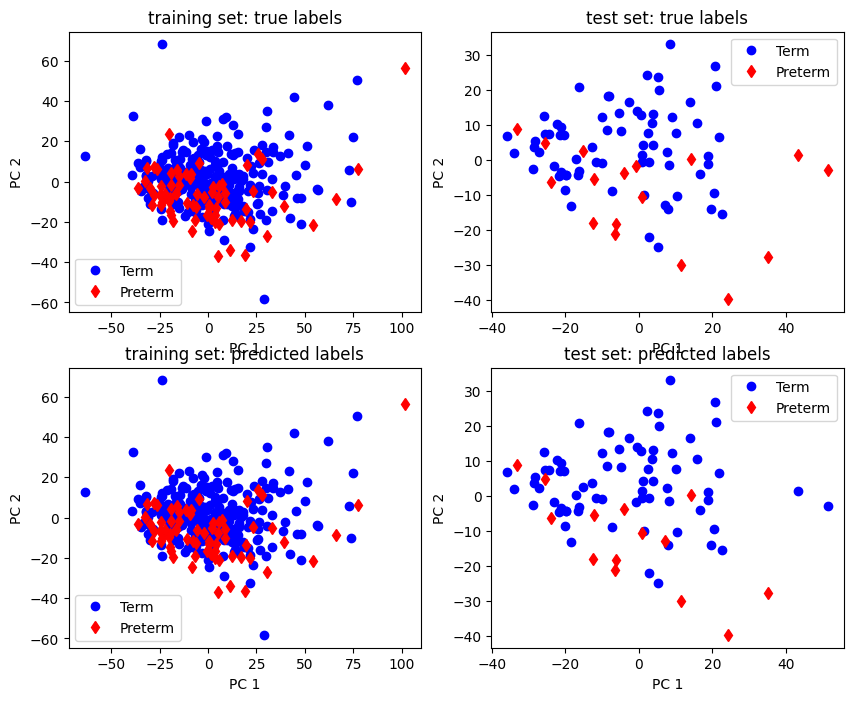

In [40]:
# plot
plt.figure(figsize=(10,8))
plt.subplot(221)
plotData(transf.transform(X_train),y_train)
plt.title('training set: true labels')
plt.subplot(222)
plotData(transf.transform(X_test),y_test)
plt.title('test set: true labels')
plt.subplot(223)
plotData(transf.transform(X_train),tuned_model.predict(X_train))
plt.title('training set: predicted labels')
plt.subplot(224)
plotData(transf.transform(X_test),tuned_model.predict(X_test))
plt.title('test set: predicted labels')

## **5.2 Random Forest Classifier**

### **5.2.1 Training Random Forest Classifier**

In [ ]:
model_2 = RandomForestClassifier(random_state=42, class_weight='balanced')

n_estimators = [int(x) for x in np.linspace(start = 300, stop = 400, num = 10)]
param_grid = {
    'bootstrap': [True, False],
    'n_estimators': n_estimators, # Number of trees in the forest
    'max_depth': [1, 2, 5],  # Maximum depth of the tree
    'min_samples_split': [3, 4, 5, 10],  # Minimum number of samples required to split a node
    'max_features': ['sqrt', 'log2']  # Number of features to consider when looking for the best split
}

grid_search_2 = GridSearchCV(model_2, cv=5, param_grid=param_grid, scoring = 'recall_macro')
_=grid_search_2.fit(X_train,y_train)


print("Best parameters found:")
print(grid_search_2.best_params_)
print('Best mean recall:', round(grid_search_2.best_score_,2))

# best model
tuned_model_2 = grid_search_2.best_estimator_

Best parameters found:
{'bootstrap': False, 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 300}
Best mean recall: 0.84


### **5.2.2 Results for Random Forest Classifier**

In [15]:
tuned_model_2 = RandomForestClassifier(random_state=42, class_weight='balanced',bootstrap = False,
                                     max_depth = 1, max_features = 'sqrt',
                                     min_samples_split = 3, n_estimators =300)

In [16]:
tuned_model_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=1,
                       min_samples_split=3, n_estimators=300, random_state=42)

In [17]:
print('Training performance:')
evaluation(tuned_model_2,X_train,y_train)

Training performance:
accuracy:  0.92
sensitivity:  0.9
specificity:  0.93
mean recall:  0.92


In [18]:
print('Training performance CV:')
evaluationCV(tuned_model_2,X_train,y_train)

Training performance CV:
CV accuracy: 0.88
CV sensitivity:  0.71
CV specificity:  0.92
CV mean recall:  0.82


Text(0.5, 1.0, 'test set: predicted labels')

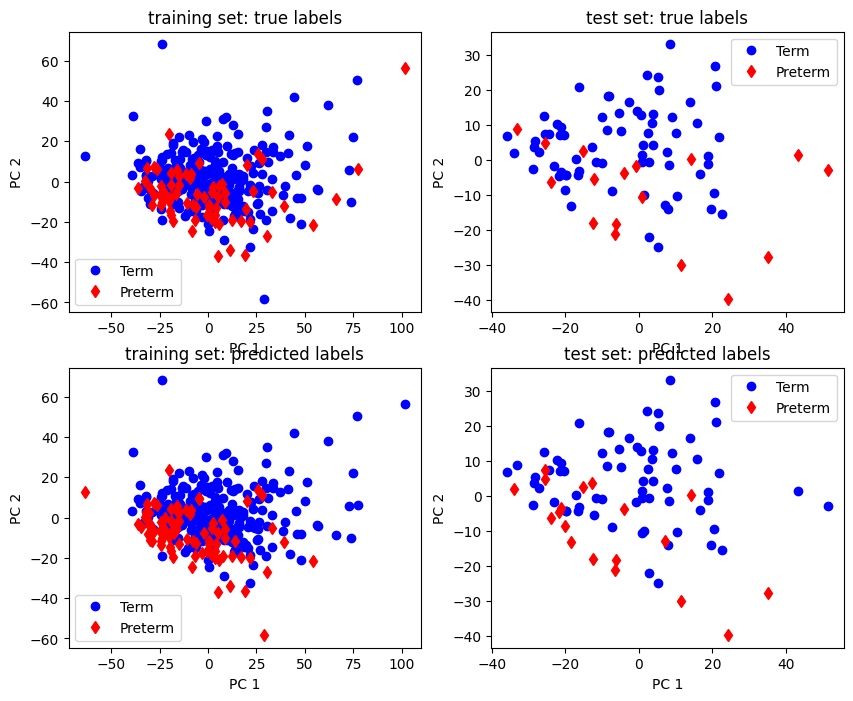

In [19]:
# plot
plt.figure(figsize=(10,8))
plt.subplot(221)
plotData(transf.transform(X_train),y_train)
plt.title('training set: true labels')
plt.subplot(222)
plotData(transf.transform(X_test),y_test)
plt.title('test set: true labels')
plt.subplot(223)
plotData(transf.transform(X_train),tuned_model_2.predict(X_train))
plt.title('training set: predicted labels')
plt.subplot(224)
plotData(transf.transform(X_test),tuned_model_2.predict(X_test))
plt.title('test set: predicted labels')

# **6. Discovering the Most Predictive Features**

## **6.1 Feature Selection using SelectKBest with ANOVA F-value**

In [20]:
def PrintTopFeatures(top_features):
    ind2D=np.unravel_index(top_features, [90,90], order='C')
    for i in range(ind2D[0].shape[0]):
        print(label_names.iloc[ind2D[0][i],1], label_names.iloc[ind2D[1][i],1] )

In [29]:
def select_k_best(model, model_params, X_train, y_train, X_test):
    # Define a pipeline with feature selection
    pipeline = Pipeline([
        ('selector', SelectKBest(f_classif)),
        ('classifier', model(**model_params))
    ])

    # Define the parameters grid for the SelectKBest
    param_grid = {'selector__k': list(range(55, 4005, 50))}

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall_macro')
    grid_search.fit(X_train, y_train)

    # Get the best k value
    best_k = grid_search.best_params_['selector__k']
    print("Best k value:", best_k)

    # Get the top features using the best k value
    selector = SelectKBest(f_classif, k=best_k)
    selector.fit(X_train, y_train)
    PrintTopFeatures(selector.get_support(indices=True))

    # Transform X_train and X_test to include only selected features
    X_train_selected_kbest = selector.transform(X_train)
    X_test_selected_kbest = selector.transform(X_test)


    return grid_search, best_k, X_train_selected_kbest, X_test_selected_kbest

### **6.1.1 Training Logistic Regression Classifier with Selected Features**

In [41]:

model = LogisticRegression
model_params = {'class_weight': 'balanced', 'C': 0.001, 'random_state' : 42}

grid_search, best_k, X_train_selected_kbest_lrc, X_test_selected_kbest_lrc  = select_k_best(model, model_params, X_train, y_train, X_test)

Best k value: 705
Precentral_L Precentral_L
Precentral_L Frontal_Sup_R 
Precentral_L Frontal_Inf_Tri_R 
Precentral_L Rolandic_Oper_R 
Precentral_L Frontal_Mid_Orb_L 
Precentral_L Cingulum_Mid_L 
Precentral_L Amygdala_R 
Precentral_L Occipital_Mid_R 
Precentral_L Postcentral_L 
Precentral_L Caudate_L 
Precentral_L Heschl_R 
Precentral_R Frontal_Mid_Orb_R 
Precentral_R Cingulum_Ant_R 
Precentral_R Hippocampus_L 
Precentral_R Lingual_L 
Precentral_R Angular_R 
Precentral_R Temporal_Sup_L 
Precentral_R Temporal_Sup_R 
Precentral_R Temporal_Mid_L 
Frontal_Sup_L  Frontal_Mid_R 
Frontal_Sup_L  Frontal_Mid_Orb_R 
Frontal_Sup_L  Frontal_Inf_Oper_R 
Frontal_Sup_L  Rolandic_Oper_L 
Frontal_Sup_L  Cingulum_Ant_L 
Frontal_Sup_L  Cingulum_Ant_R 
Frontal_Sup_L  Cingulum_Post_L 
Frontal_Sup_L  ParaHippocampal_L 
Frontal_Sup_L  Occipital_Sup_R 
Frontal_Sup_L  Occipital_Mid_L 
Frontal_Sup_L  Occipital_Inf_R 
Frontal_Sup_L  Postcentral_R 
Frontal_Sup_L  Paracentral_Lobule_R 
Frontal_Sup_L  Pallidum_L 
Fr

In [42]:
kbest_lrc = model(**model_params)

In [43]:
kbest_lrc.fit(X_train_selected_kbest_lrc, y_train)

LogisticRegression(C=0.001, class_weight='balanced', random_state=42)

In [44]:
print('Training performance:')
evaluation(kbest_lrc,X_train_selected_kbest_lrc,y_train)

Training performance:
accuracy:  0.97
sensitivity:  0.99
specificity:  0.96
mean recall:  0.97


In [45]:
print('Training performance CV:')
evaluationCV(kbest_lrc,X_train_selected_kbest_lrc,y_train)

Training performance CV:
CV accuracy: 0.93
CV sensitivity:  0.87
CV specificity:  0.94
CV mean recall:  0.91


### **6.1.2 Training Random Forest Classifier with Selected Features**

In [48]:
model_2 = RandomForestClassifier
model_params_2 = {'random_state':42, 'class_weight' :'balanced', 'bootstrap' : False,
                                     'max_depth' : 1, 'max_features' : 'sqrt',
                                     'min_samples_split' : 3, 'n_estimators' : 300}


grid_search_2, best_k_2, X_train_selected_kbest_rfc, X_test_selected_kbest_rfc  = select_k_best(model_2, model_params_2, X_train, y_train, X_test)

Best k value: 405
Precentral_L Rolandic_Oper_R 
Precentral_L Frontal_Mid_Orb_L 
Precentral_L Cingulum_Mid_L 
Precentral_L Occipital_Mid_R 
Precentral_L Heschl_R 
Precentral_R Hippocampus_L 
Precentral_R Angular_R 
Precentral_R Temporal_Sup_R 
Precentral_R Temporal_Mid_L 
Frontal_Sup_L  Frontal_Mid_R 
Frontal_Sup_L  Frontal_Inf_Oper_R 
Frontal_Sup_L  Rolandic_Oper_L 
Frontal_Sup_L  Cingulum_Ant_R 
Frontal_Sup_L  ParaHippocampal_L 
Frontal_Sup_L  Occipital_Inf_R 
Frontal_Sup_L  Paracentral_Lobule_R 
Frontal_Sup_L  Thalamus_L 
Frontal_Sup_R  Frontal_Sup_L 
Frontal_Sup_R  Parietal_Inf_R 
Frontal_Sup_R  Angular_R 
Frontal_Sup_R  Precuneus_R 
Frontal_Sup_Orb_L  Rolandic_Oper_L 
Frontal_Sup_Orb_L  Frontal_Mid_Orb_L 
Frontal_Sup_Orb_L  Occipital_Mid_R 
Frontal_Sup_Orb_L  Occipital_Inf_R 
Frontal_Sup_Orb_L  Fusiform_R 
Frontal_Sup_Orb_L  Parietal_Inf_R 
Frontal_Sup_Orb_L  Putamen_R 
Frontal_Sup_Orb_R  Frontal_Inf_Oper_R 
Frontal_Sup_Orb_R  Olfactory_L 
Frontal_Sup_Orb_R  Frontal_Mid_Orb_L 
Fron

In [49]:
kbest_rfc = model_2(**model_params_2)

In [50]:
kbest_rfc.fit(X_train_selected_kbest_rfc, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=1,
                       min_samples_split=3, n_estimators=300, random_state=42)

In [51]:
print('Training performance:')
evaluation(kbest_rfc,X_train_selected_kbest_rfc,y_train)

Training performance:
accuracy:  0.93
sensitivity:  0.89
specificity:  0.94
mean recall:  0.91


In [52]:
print('Training performance CV:')
evaluationCV(kbest_rfc,X_train_selected_kbest_rfc,y_train)

Training performance CV:
CV accuracy: 0.87
CV sensitivity:  0.76
CV specificity:  0.9
CV mean recall:  0.83


## **6.2 Comparing Test Set Results**

### **6.2.1 Logistic Regression Classifier**

In [36]:
print('Test performance:')
evaluation(tuned_model,X_test,y_test)

Test performance:
accuracy:  0.94
sensitivity:  0.76
specificity:  0.99
mean recall:  0.88


### **6.2.2 Logistic Regression Classifier & SelectKBest**

In [46]:
print('Test performance:')
evaluation(kbest_lrc, X_test_selected_kbest_lrc,y_test)

Test performance:
accuracy:  0.93
sensitivity:  0.76
specificity:  0.97
mean recall:  0.87


### **6.2.3 Random Forest Classifier**

In [47]:
print('Test performance:')
evaluation(tuned_model_2,X_test,y_test)

Test performance:
accuracy:  0.84
sensitivity:  0.65
specificity:  0.89
mean recall:  0.77


### **6.2.4 Random Forest Classifier & SelectKBest**

In [53]:
print('Test performance:')
evaluation(kbest_rfc, X_test_selected_kbest_rfc,y_test)

Test performance:
accuracy:  0.86
sensitivity:  0.71
specificity:  0.9
mean recall:  0.8
